In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import random as rand
import matplotlib.pyplot as plt 
%matplotlib inline


torch.manual_seed(24)    



In [2]:
'''
STEP 1: LOADING DATASET
'''

dataset = dsets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = dsets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
'''
STEP 2: SPLIT DATA TO TRAINING AND VALIDATION
'''
#validation set size 5000 
val_size = 5000
train_size = len(dataset) - val_size

#creating training & validation set using random_split
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
len(train_dataset), len(val_dataset)

(45000, 5000)

In [4]:
'''
STEP 3: MAKING DATASET ITERABLE
'''
#Creating data loader to load data in batches
batch_size=124
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size*2, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)


In [5]:
'''
Step 4 : Creat Model class
'''

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(input_size, 300)
        # output layer
        self.linear2 = nn.Linear(300, output_size)
        
    def forward(self, x):
        # Flatten images into vectors
        out = x.view(x.size(0), -1)
        # Apply layers & activation functions
        out = self.linear1(out)
        # Apply activation function
        out = torch.nn.functional.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        # Apply activation function
        out = torch.nn.functional.relu(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = torch.nn.functional.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = torch.nn.functional.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

input_size = 3*32*32
output_size = 10
model = CIFAR10Model()

In [6]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [7]:
'''
Step 5: Move model and data to GPU if availble 
'''

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)
def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

model = to_device(model, device)

In [8]:
'''
Step 5: Train Model
'''
history = [evaluate(model, val_loader)]
history # initial Loss and accuracy

[{'val_acc': 0.08128955960273743, 'val_loss': 2.303903818130493}]

In [9]:
#history += fit(10, 0.05, model, train_loader, val_loader)


In [10]:
#history += fit(8, 0.005, model, train_loader, val_loader)


In [11]:
#history += fit(7, 0.01, model, train_loader, val_loader)


In [12]:
#history += fit(4, 0.001, model, train_loader, val_loader)


In [13]:
#history += fit(5, 0.1, model, train_loader, val_loader)


In [14]:
#history += fit(10, 0.0001, model, train_loader, val_loader)


In [15]:
# best model found was (increase number of epochs)
history += fit(50, 0.06, model, train_loader, val_loader)


Epoch [0], val_loss: 2.1370, val_acc: 0.2694
Epoch [1], val_loss: 1.9472, val_acc: 0.3093
Epoch [2], val_loss: 2.0747, val_acc: 0.3048
Epoch [3], val_loss: 1.7235, val_acc: 0.3900
Epoch [4], val_loss: 1.6995, val_acc: 0.4031
Epoch [5], val_loss: 1.7708, val_acc: 0.3900
Epoch [6], val_loss: 1.8277, val_acc: 0.3720
Epoch [7], val_loss: 1.6123, val_acc: 0.4474
Epoch [8], val_loss: 1.5867, val_acc: 0.4335
Epoch [9], val_loss: 2.0816, val_acc: 0.3538
Epoch [10], val_loss: 1.9783, val_acc: 0.3390
Epoch [11], val_loss: 1.7999, val_acc: 0.3831
Epoch [12], val_loss: 1.5135, val_acc: 0.4749
Epoch [13], val_loss: 1.9367, val_acc: 0.3768
Epoch [14], val_loss: 1.4988, val_acc: 0.4798
Epoch [15], val_loss: 1.8020, val_acc: 0.4037
Epoch [16], val_loss: 1.6247, val_acc: 0.4440
Epoch [17], val_loss: 2.0446, val_acc: 0.3675
Epoch [18], val_loss: 1.7357, val_acc: 0.4458
Epoch [19], val_loss: 2.2024, val_acc: 0.3604
Epoch [20], val_loss: 1.7607, val_acc: 0.4341
Epoch [21], val_loss: 1.6783, val_acc: 0.433

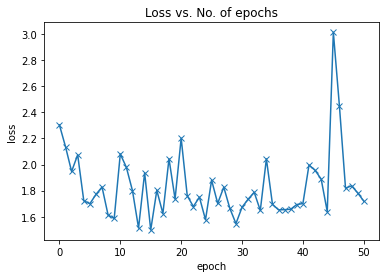

In [16]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)


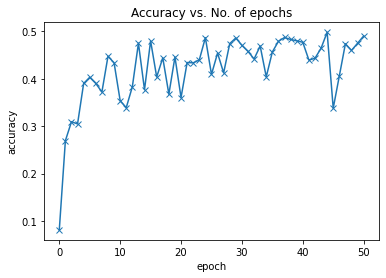

In [17]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
plot_accuracies(history)


In [18]:
evaluate(model, test_loader) # its displayed as validation loss and accuracy, but this is the test loss

{'val_acc': 0.4917396605014801, 'val_loss': 1.682762622833252}

### Hyper Parameter Optimization

In [19]:
from hyperopt import hp, tpe, fmin
def run_model(learning_rate):
  model = CIFAR10Model()
  model = to_device(model, device)
  error = fit(1, learning_rate, model, train_loader, val_loader)
  return error[-1]["val_loss"]


best = fmin(fn=lambda x: run_model(x),
            space=hp.uniform('x', 0.01, 1),
            algo=tpe.suggest, 
            max_evals=100)
print("Best Learning Rate",best)

Epoch [0], val_loss: 2.3026, val_acc: 0.1042
Epoch [0], val_loss: 2.3026, val_acc: 0.1042
Epoch [0], val_loss: 2.3026, val_acc: 0.1042
Epoch [0], val_loss: 2.3026, val_acc: 0.1042
Epoch [0], val_loss: 2.3026, val_acc: 0.1042
Epoch [0], val_loss: 2.3026, val_acc: 0.1042
Epoch [0], val_loss: 2.3026, val_acc: 0.1042
Epoch [0], val_loss: 2.3026, val_acc: 0.1042
Epoch [0], val_loss: 2.3026, val_acc: 0.1042
Epoch [0], val_loss: 2.3026, val_acc: 0.1042
Epoch [0], val_loss: 2.3026, val_acc: 0.1042
Epoch [0], val_loss: 2.3026, val_acc: 0.1042
Epoch [0], val_loss: 2.3026, val_acc: 0.1042
Epoch [0], val_loss: 2.3026, val_acc: 0.1042
Epoch [0], val_loss: 2.3140, val_acc: 0.1454
Epoch [0], val_loss: 2.3026, val_acc: 0.1042
Epoch [0], val_loss: 2.3026, val_acc: 0.1042
Epoch [0], val_loss: 2.3026, val_acc: 0.1042
Epoch [0], val_loss: 2.2591, val_acc: 0.1394
Epoch [0], val_loss: 2.3026, val_acc: 0.1042
Epoch [0], val_loss: 2.4840, val_acc: 0.2219
Epoch [0], val_loss: 2.3026, val_acc: 0.1042
Epoch [0],

In [20]:
def run_model(batch_size):
  model = CIFAR10Model()
  batch_size=batch_size
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size*2, num_workers=4, pin_memory=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)
  train_loader = DeviceDataLoader(train_loader, device)
  val_loader = DeviceDataLoader(val_loader, device)
  test_loader = DeviceDataLoader(test_loader, device)
  model = to_device(model, device)
  error = fit(1, 0.06, model, train_loader, val_loader)
  return error[-1]["val_loss"]


best = fmin(fn=lambda x: run_model(x),
            space=hp.choice('x',[1,32,64,124,256,512,1024]),
            algo=tpe.suggest, 
            max_evals=10)
print("Best Batch Size",best)

Epoch [0], val_loss: 2.2146, val_acc: 0.2101
Epoch [0], val_loss: 2.3026, val_acc: 0.1054
Epoch [0], val_loss: 1.9134, val_acc: 0.3164
Epoch [0], val_loss: 2.0514, val_acc: 0.2913
Epoch [0], val_loss: 2.1303, val_acc: 0.2236
Epoch [0], val_loss: 2.1017, val_acc: 0.2755
Epoch [0], val_loss: 2.0669, val_acc: 0.2848
Epoch [0], val_loss: 2.0710, val_acc: 0.2580
Epoch [0], val_loss: 1.9438, val_acc: 0.3024
Epoch [0], val_loss: 2.1331, val_acc: 0.2642
100%|██████████| 10/10 [03:01<00:00, 18.19s/it, best loss: 1.9134082794189453]
Best Batch Size {'x': 3}
